In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/ECEC247_Project

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/ECEC247_Project


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras 
from keras import models
from keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.layers import TimeDistributed
from tensorflow.keras.regularizers import L1L2
!pip install pyts

In [ ]:
from pyts.image import GramianAngularField

In [ ]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))
y_train_valid -= 769
y_test -= 769

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [ ]:
id = 1
X_train_valid_SingleSubject = X_train_valid[np.where(person_train_valid == id)[0]]
y_train_valid_SingleSubject = y_train_valid[np.where(person_train_valid == id)[0]]

In [ ]:
X_train_valid_SingleSubject.shape

(236, 22, 1000)

In [ ]:
ind_valid = np.random.choice(X_train_valid_SingleSubject.shape[0], 36, replace=False)
ind_train = np.array(list(set(range(X_train_valid_SingleSubject.shape[0])).difference(set(ind_valid))))

In [ ]:
(x_train, x_valid) = X_train_valid_SingleSubject[ind_train], X_train_valid_SingleSubject[ind_valid] 
(y_train, y_valid) = y_train_valid_SingleSubject[ind_train], y_train_valid_SingleSubject[ind_valid]

In [ ]:
def data_prep(X,y,trim,sub_sample,average,noise,willMaxPool,willAverage,willSubsample):
    
    total_X = np.zeros((1, X.shape[1], int(X.shape[2]/sub_sample)))
    total_y = np.zeros((1))
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:trim]
    print('Shape of X after trimming:',X.shape)
    
    if willMaxPool:
        # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
        X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
        total_X = np.vstack((total_X,X_max))
        total_y = np.hstack((total_y, y))
        print('Shape of X after maxpooling:',total_X.shape)
    
    
    # Averaging + noise 
    if willAverage:
        X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
        if noise:
            X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
        total_X = np.vstack((total_X, X_average))
        total_y = np.hstack((total_y, y))
        print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    if willSubsample:
        for i in range(sub_sample):
            
            X_subsample = X[:, :, i::sub_sample] + \
                                (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
                
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
            
        
        print('Shape of X after subsampling and concatenating:',total_X.shape)
    
    total_X=total_X[1:,:,:]
    total_y=total_y[1:]
    return total_X,total_y

In [ ]:
X_train_prep,y_train_prep = data_prep(x_train,y_train,1000,2,2,
                                                           noise=True,willMaxPool=True,
                                                           willAverage=True, willSubsample=True)
X_valid_prep,y_valid_prep = data_prep(x_valid,y_valid,1000,2,2,
                                                           noise=True,willMaxPool=True,
                                                           willAverage=True,willSubsample=True)

y_trainCat = to_categorical(y_train_prep, 4)
y_validCat = to_categorical(y_valid_prep, 4)

Shape of X after trimming: (200, 22, 1000)
Shape of X after maxpooling: (201, 22, 500)
Shape of X after averaging+noise and concatenating: (401, 22, 500)
Shape of X after subsampling and concatenating: (601, 22, 500)
Shape of X after trimming: (36, 22, 1000)
Shape of X after maxpooling: (37, 22, 500)
Shape of X after averaging+noise and concatenating: (73, 22, 500)
Shape of X after subsampling and concatenating: (109, 22, 500)


In [ ]:
def fitTransformGramianTimeSeries(dataset,imgSize,timeStep):
    gcfs = {}
    amountOfTime = dataset.shape[2]
    noOfImages = int(amountOfTime / timeStep)
    amountOfFeatures = dataset.shape[1]
    amountOfSamples = dataset.shape[0]
    imageOut = np.empty((amountOfSamples,noOfImages,imgSize,imgSize, amountOfFeatures))
    for k in range(amountOfFeatures):
        feature = dataset[:,k,:]
        gcf = GramianAngularField(image_size=imgSize,method='d')
        gcf = gcf.fit(feature)
        string = "gcf"+str(k)
        gcfs[string] = gcf
        seperated = np.array_split(feature, noOfImages, axis=1)

        for ind in range(len(seperated)):
            section = seperated[ind]
            newImage = gcf.transform(section)
            imageOut[:,ind,:,:,k] = newImage

    return gcfs,imageOut

def transformGramianTimeStep(dataset,gcfs,imgSize,timeStep):
    amountOfTime = dataset.shape[2]
    noOfImages = int(amountOfTime / timeStep)
    amountOfFeatures = dataset.shape[1]
    amountOfSamples = dataset.shape[0]
    imageOut = np.empty((amountOfSamples,noOfImages,imgSize,imgSize, amountOfFeatures))
    for k in range(amountOfFeatures):
        feature = dataset[:,k,:]
        seperated = np.array_split(feature, noOfImages, axis=1)
        string = "gcf"+str(k)
        gcf = gcfs[string]
        for ind in range(len(seperated)):
            section = seperated[ind]
            newImage = gcf.transform(section)
            imageOut[:,ind,:,:,k] = newImage
    return imageOut

In [ ]:
gcfs,trainImages = fitTransformGramianTimeSeries(X_train_prep,30,100)
valImages = transformGramianTimeStep(X_valid_prep,gcfs,30,100)
print(trainImages.shape)
print(valImages.shape)

(600, 5, 30, 30, 22)
(108, 5, 30, 30, 22)


In [ ]:
l2Strength=0.1
l1Strength=0.00
kernelSize = 2

inp = layers.Input((trainImages.shape[1], trainImages.shape[2], trainImages.shape[3], trainImages.shape[4]))
hidden = TimeDistributed(layers.Conv2D(filters=32, 
                                       kernel_regularizer=L1L2(l1=l1Strength, l2=l2Strength),
                                       kernel_size=(kernelSize,kernelSize), padding='same', activation='elu'))(inp)
hidden = TimeDistributed(layers.MaxPooling2D(pool_size=(2,2), padding='same'))(hidden)
hidden = TimeDistributed(layers.BatchNormalization())(hidden)
hidden = TimeDistributed(layers.Dropout(0.5))(hidden)

#hidden = TimeDistributed(layers.Conv2D(filters=16, 
#                                       kernel_regularizer=L1L2(l1=l1Strength, l2=l2Strength),
#                                       kernel_size=(kernelSize,kernelSize), padding='same', activation='elu'))(inp)
#hidden = TimeDistributed(layers.MaxPooling2D(pool_size=(2,2), padding='same'))(hidden)
#hidden = TimeDistributed(layers.BatchNormalization())(hidden)
#hidden = TimeDistributed(layers.Dropout(0.5))(hidden)

hidden = TimeDistributed(layers.Flatten())(hidden)
#hidden = layers.Bidirectional(layers.LSTM(64,return_sequences=True))(hidden)
hidden = layers.Bidirectional(layers.LSTM(16,return_sequences=False))(hidden)
hidden = layers.Dropout(0.5)(hidden)
hidden = layers.Dense(4, kernel_regularizer=L1L2(l1=l1Strength, l2=l2Strength),activation='softmax')(hidden)

model = tf.keras.models.Model(inputs=inp, outputs=hidden)
model.summary()

In [ ]:
epochs = 20
optimizer = keras.optimizers.Adam(lr=0.001,epsilon=1e-8, decay=0.001)

model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
results = model.fit(trainImages,
             y_trainCat,
             batch_size=32,
             epochs=epochs,
             validation_data=(valImages, y_validCat), verbose=True)

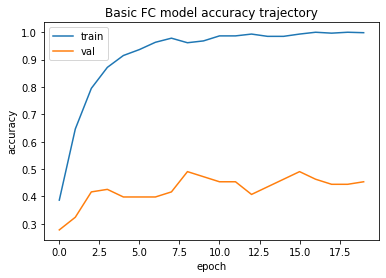

In [ ]:
import matplotlib.pyplot as plt
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Basic FC model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
X_test_SingleSubject = X_test[np.where(person_test == id)[0]]
y_test_SingleSubject = y_test[np.where(person_test == id)[0]]

X_test_prep,y_test_prep = data_prep(X_test_SingleSubject,y_test_SingleSubject,1000,2,2,noise=False,willMaxPool=False,
                                                           willAverage=False,willSubsample=True)
y_testCat = to_categorical(y_test_prep, 4)

testImages = transformGramianTimeStep(X_test_prep,gcfs,30,100)


Shape of X after trimming: (50, 22, 1000)
Shape of X after subsampling and concatenating: (51, 22, 500)


In [ ]:
modelScore = model.evaluate(testImages, y_testCat, verbose=1)
print('Test accuracy of the hybrid CNN-LSTM model:',modelScore[1])

2/2 [==============================] - 0s 34ms/step - loss: 1.7426 - accuracy: 0.4200
Test accuracy of the hybrid CNN-LSTM model: 0.41999998688697815


In [ ]:
#########################################################################################
#NOW I AM GOING TO TRAIN ACROSS ALL TEST SUBJECTS AND SEE PERFORMANCE CHANGE ON SUBJECT 1
#########################################################################################

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/ECEC247_Project

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/ECEC247_Project


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras 
from keras import models
from keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.layers import TimeDistributed
from tensorflow.keras.regularizers import L1L2
!pip install pyts

In [ ]:
from pyts.image import GramianAngularField

In [ ]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))
y_train_valid -= 769
y_test -= 769

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [ ]:
ind_valid = np.random.choice(X_train_valid.shape[0], 500, replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

In [ ]:
def data_prep(X,y,trim,sub_sample,average,noise,willMaxPool,willAverage,willSubsample):
    
    total_X = np.zeros((1, X.shape[1], int(X.shape[2]/sub_sample)))
    total_y = np.zeros((1))
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:trim]
    print('Shape of X after trimming:',X.shape)
    
    if willMaxPool:
        # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
        X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
        total_X = np.vstack((total_X,X_max))
        total_y = np.hstack((total_y, y))
        print('Shape of X after maxpooling:',total_X.shape)
    
    
    # Averaging + noise 
    if willAverage:
        X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
        if noise:
            X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
        total_X = np.vstack((total_X, X_average))
        total_y = np.hstack((total_y, y))
        print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    if willSubsample:
        for i in range(sub_sample):
            
            X_subsample = X[:, :, i::sub_sample] + \
                                (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
                
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
            
        
        print('Shape of X after subsampling and concatenating:',total_X.shape)
    
    total_X=total_X[1:,:,:]
    total_y=total_y[1:]
    return total_X,total_y
def fitTransformGramianTimeSeries(dataset,imgSize,timeStep):
    gcfs = {}
    amountOfTime = dataset.shape[2]
    noOfImages = int(amountOfTime / timeStep)
    amountOfFeatures = dataset.shape[1]
    amountOfSamples = dataset.shape[0]
    imageOut = np.empty((amountOfSamples,noOfImages,imgSize,imgSize, amountOfFeatures))
    for k in range(amountOfFeatures):
        feature = dataset[:,k,:]
        gcf = GramianAngularField(image_size=imgSize,method='d')
        gcf = gcf.fit(feature)
        string = "gcf"+str(k)
        gcfs[string] = gcf
        seperated = np.array_split(feature, noOfImages, axis=1)

        for ind in range(len(seperated)):
            section = seperated[ind]
            newImage = gcf.transform(section)
            imageOut[:,ind,:,:,k] = newImage

    return gcfs,imageOut

def transformGramianTimeStep(dataset,gcfs,imgSize,timeStep):
    amountOfTime = dataset.shape[2]
    noOfImages = int(amountOfTime / timeStep)
    amountOfFeatures = dataset.shape[1]
    amountOfSamples = dataset.shape[0]
    imageOut = np.empty((amountOfSamples,noOfImages,imgSize,imgSize, amountOfFeatures))
    for k in range(amountOfFeatures):
        feature = dataset[:,k,:]
        seperated = np.array_split(feature, noOfImages, axis=1)
        string = "gcf"+str(k)
        gcf = gcfs[string]
        for ind in range(len(seperated)):
            section = seperated[ind]
            newImage = gcf.transform(section)
            imageOut[:,ind,:,:,k] = newImage
    return imageOut

In [ ]:
X_train_prep,y_train_prep = data_prep(x_train,y_train,1000,2,2,
                                                           noise=True,willMaxPool=True,
                                                           willAverage=True, willSubsample=True)
X_valid_prep,y_valid_prep = data_prep(x_valid,y_valid,1000,2,2,
                                                           noise=True,willMaxPool=True,
                                                           willAverage=True,willSubsample=True)

y_trainCat = to_categorical(y_train_prep, 4)
y_validCat = to_categorical(y_valid_prep, 4)

Shape of X after trimming: (1615, 22, 1000)
Shape of X after maxpooling: (1616, 22, 500)
Shape of X after averaging+noise and concatenating: (3231, 22, 500)
Shape of X after subsampling and concatenating: (4846, 22, 500)
Shape of X after trimming: (500, 22, 1000)
Shape of X after maxpooling: (501, 22, 500)
Shape of X after averaging+noise and concatenating: (1001, 22, 500)
Shape of X after subsampling and concatenating: (1501, 22, 500)


In [ ]:
gcfs,trainImages = fitTransformGramianTimeSeries(X_train_prep,30,100)
valImages = transformGramianTimeStep(X_valid_prep,gcfs,30,100)
print(trainImages.shape)
print(valImages.shape)

(4845, 5, 30, 30, 22)
(1500, 5, 30, 30, 22)


In [ ]:
l2Strength=0.1
l1Strength=0.00
kernelSize = 2

inp = layers.Input((trainImages.shape[1], trainImages.shape[2], trainImages.shape[3], trainImages.shape[4]))
hidden = TimeDistributed(layers.Conv2D(filters=8, 
                                       kernel_regularizer=L1L2(l1=l1Strength, l2=l2Strength),
                                       kernel_size=(kernelSize,kernelSize), padding='same', activation='elu'))(inp)
hidden = TimeDistributed(layers.MaxPooling2D(pool_size=(2,2), padding='same'))(hidden)
hidden = TimeDistributed(layers.BatchNormalization())(hidden)
hidden = TimeDistributed(layers.Dropout(0.5))(hidden)

hidden = TimeDistributed(layers.Conv2D(filters=10, 
                                       kernel_regularizer=L1L2(l1=l1Strength, l2=l2Strength),
                                       kernel_size=(kernelSize,kernelSize), padding='same', activation='elu'))(inp)
hidden = TimeDistributed(layers.MaxPooling2D(pool_size=(2,2), padding='same'))(hidden)
hidden = TimeDistributed(layers.BatchNormalization())(hidden)
hidden = TimeDistributed(layers.Dropout(0.5))(hidden)

hidden = TimeDistributed(layers.Flatten())(hidden)
#hidden = layers.Bidirectional(layers.LSTM(64,return_sequences=True))(hidden)
hidden = layers.Bidirectional(layers.LSTM(32,return_sequences=False))(hidden)
hidden = layers.Dropout(0.5)(hidden)
hidden = layers.Dense(4, kernel_regularizer=L1L2(l1=l1Strength, l2=l2Strength),activation='softmax')(hidden)

model = tf.keras.models.Model(inputs=inp, outputs=hidden)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 30, 30, 22)]   0         
                                                                 
 time_distributed_4 (TimeDis  (None, 5, 30, 30, 10)    890       
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 5, 15, 15, 10)    0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 5, 15, 15, 10)    40        
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 5, 15, 15, 10)    0         
 tributed)                                                   

In [ ]:
epochs = 30
optimizer = keras.optimizers.Adam(lr=0.001,epsilon=1e-8, decay=0.001)

model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
results = model.fit(trainImages,
             y_trainCat,
             batch_size=32,
             epochs=epochs,
             validation_data=(valImages, y_validCat), verbose=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
152/152 [==============================] - 20s 44ms/step - loss: 2.5634 - accuracy: 0.3197 - val_loss: 1.9894 - val_accuracy: 0.2660
Epoch 2/30
152/152 [==============================] - 4s 27ms/step - loss: 1.6303 - accuracy: 0.4712 - val_loss: 1.6356 - val_accuracy: 0.2893
Epoch 3/30
152/152 [==============================] - 4s 26ms/step - loss: 1.3741 - accuracy: 0.5564 - val_loss: 1.5235 - val_accuracy: 0.3160
Epoch 4/30
152/152 [==============================] - 4s 26ms/step - loss: 1.2491 - accuracy: 0.6266 - val_loss: 1.4868 - val_accuracy: 0.3613
Epoch 5/30
152/152 [==============================] - 4s 26ms/step - loss: 1.1615 - accuracy: 0.6873 - val_loss: 1.4988 - val_accuracy: 0.3427
Epoch 6/30
152/152 [==============================] - 4s 26ms/step - loss: 1.0869 - accuracy: 0.7286 - val_loss: 1.4924 - val_accuracy: 0.3513
Epoch 7/30
152/152 [==============================] - 4s 26ms/step - loss: 1.0185 - accuracy: 0.7730 - val_loss: 1.5038 - val_accuracy: 0.368

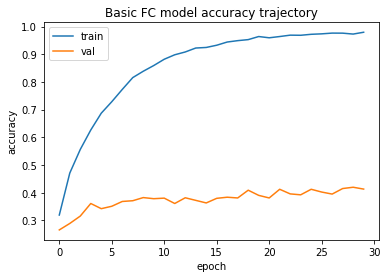

In [ ]:
import matplotlib.pyplot as plt
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Basic FC model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
id=1
X_test_SingleSubject = X_test[np.where(person_test == id)[0]]
y_test_SingleSubject = y_test[np.where(person_test == id)[0]]

X_test_prep,y_test_prep = data_prep(X_test_SingleSubject,y_test_SingleSubject,1000,2,2,noise=False,willMaxPool=False,
                                                           willAverage=True,willSubsample=False)
y_testCat = to_categorical(y_test_prep, 4)

testImages = transformGramianTimeStep(X_test_prep,gcfs,30,100)

Shape of X after trimming: (50, 22, 1000)
Shape of X after averaging+noise and concatenating: (51, 22, 500)


In [ ]:
modelScore = model.evaluate(testImages, y_testCat, verbose=1)
print('Test accuracy of the hybrid CNN-LSTM model:',modelScore[1])

2/2 [==============================] - 0s 34ms/step - loss: 1.5326 - accuracy: 0.3800
Test accuracy of the hybrid CNN-LSTM model: 0.3799999952316284
